# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reedemus/dog_breed_classifier/blob/master/dog_app.ipynb)
---
In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/sample_dog_output.png?raw=1)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

### Google Colab (Optional)
The code below is required if the notebook is opened in Google Colab. It will help you to download the datasets and openCV face detector file into the colab instance.

In [ ]:
import os, shutil, requests
from google.colab import drive 
from zipfile import ZipFile
from tqdm import tqdm
from google.colab import drive

# define a flag to track if notebook is running in Colab session
isColabRunning = False

def isRunningColab():
    '''
    Check if notebook is running in a Google Colab environment.
    If yes, return True otherwise False.
    '''
    if 'google.colab' in str(get_ipython()):
        print('Running in Colab\n')
        isColab = True
        return True
    else:
        isColab = False
        return False

def saveToDrive(file_name):
    # save to Drive's root directory
    drive.mount('/content/drive')
    path = os.path.join('/content/drive/MyDrive/', file_name)
    shutil.copy2(file_name, path)
    print(file_name, 'copied to Drive.')
    drive.flush_and_unmount()

def loadFromDrive(file_name):
    # load from Drive's root directory
    drive.mount('/content/drive')
    path = os.path.join('/content/drive/MyDrive/', file_name)
    shutil.copy2( path, '.' )
    print(file_name, 'loaded from Drive.')
    drive.flush_and_unmount()

def downloadFile(file_url, file_name, dir=None, chunk_size=1024):
    '''
    Helper function to download file to specified directory

    :param file_url: file download URL
    :param file_name: file name to be saved.
    :param dir: path where file is saved other than current directory (Default = current working directory)
    :param chunk_size: size of file chunk to download (Default = 1024 bytes)
    :returns: None
    '''
    saved_file_path = file_name
    if dir != None and not os.path.exists(dir):
        os.mkdir(dir)
        saved_file_path = os.path.join(dir, file_name)

    r = requests.get(file_url, stream=True)
    total_size_in_bytes = len(r.content)
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=file_name)
    
    with open(saved_file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size):
            progress_bar.update(len(chunk))
            # writing one chunk at a time to file
            if chunk:
                f.write(chunk)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
       print("ERROR, something went wrong")
       return

def extractFile(file_name):
    # create a zipfile object and extract it to current directory
    print("Extracting file...")
    with ZipFile(file_name, 'r') as z:
        z.extractall()

def colabSetup():
    '''
    Download datasets and openCV face detector xml file into Colab instance.
    '''
    print('Downloading datasets and openCV classifiers...')

    dog_url = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'
    lfw_url = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip'
    face_detector_url = 'https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_alt.xml' # raw xml file link
    
    downloadFile(dog_url, 'dogImages.zip')
    extractFile('dogImages.zip')
    downloadFile(lfw_url, 'lfw.zip')
    extractFile('lfw.zip')
    downloadFile(face_detector_url, 'haarcascade_frontalface_alt.xml', './haarcascades')
    print('\n...DONE')

# check if notebook is running in a Colab session
isColabRunning = isRunningColab()

if isColabRunning:
    colabSetup()


In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


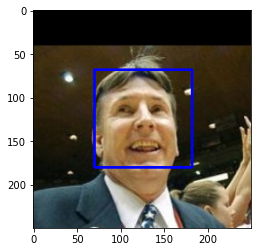

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
count_humans = 0
count_dogs = 0
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
for human_file_path in tqdm(human_files_short, desc = "human_files (first 100 images)"):
    if face_detector(human_file_path):
        count_humans += 1
#    else:
#        print("Not a human face at index:", np.where(human_files_short == file), ",\nin file", str(file))
#        img1 = cv2.imread(file)
        # convert BGR image to RGB for plotting
#        cv_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
#        plt.imshow(cv_rgb)
#        plt.show()
print("Percentage of detected human faces in human_files:", str(count_humans), "%")

for dog_file_path in tqdm(dog_files_short, desc = "dog_files (first 100 images)"):
    if face_detector(dog_file_path):
        count_dogs += 1
print("Percentage of detected human faces in dog_files:", str(count_dogs), "%")

dog_files (first 100 images):   0%|          | 0/100 [00:00<?, ?it/s]

Percentage of detected human faces in human_files: 99 %


dog_files (first 100 images): 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]

Percentage of detected human faces in dog_files: 8 %


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](https://pytorch.org/vision/stable/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    input_img = Image.open(img_path)

    # Preprocess the input image to the input pixel height, width
    # Normalize using mean and std deviation values from ImageNet models
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )])

    # Returns a tensor of shape (color channels=3, height, width)
    input_tensor = preprocess(input_img)
    
    # PyTorch pretrained models expect tensor dims to be (batch_size, color channels, height, width).
    # However, we have (color channels, height, width); fix this by inserting a new axis at index 0,
    # i.e. in front of the other axes/dims.
    input_batch = input_tensor.unsqueeze(0)

    # use GPU if available
    if use_cuda:
        input_batch = input_batch.cuda()

    # Set to eval mode to use pretrained weights
    VGG16.eval()
    pred = VGG16(input_batch)
    #print("pred = {}, shape = {}".format(pred, pred.shape))

    # Get index of the maximum value in the tensor
    index = torch.argmax(pred, dim=1)

    return int(index) # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    retVal = False
    index = VGG16_predict(img_path)
    if index >= 151 and index <= 268:
        retVal = True
    else:
        retVal = False
    return retVal

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__
- Percentage of dogs found in human_files_short = 0%
- Percentage of dogs found in dogs_files_short = 98%


In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

resultA = 0
resultB = 0
for img in tqdm(human_files_short, desc = "human_files_short"):
    if dog_detector(img) == True:
        resultA += 1
print("\nPercentage of dogs found in human_files_short: {}%".format(resultA))

for img in tqdm(dog_files_short, desc = "dog_files_short"):
    if dog_detector(img) == True:
        resultB += 1
print("\nPercentage of dogs found in dog_files_short: {}%".format(resultB))

dog_files_short:   3%|▎         | 3/100 [00:00<00:04, 20.43it/s]


Percentage of dogs found in human_files_short: 0%


dog_files_short: 100%|██████████| 100/100 [00:04<00:00, 21.65it/s]


Percentage of dogs found in dog_files_short: 98%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/Labrador_retriever_06449.jpg?raw=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
root_dir = 'dogImages/'
train_dir = os.path.join(root_dir, 'train')
valid_dir = os.path.join(root_dir, 'valid')
test_dir = os.path.join(root_dir, 'test')
IMG_SIZE = 256

# Data augmentation to create a variety of test images so the model learn to generalize better.
# Output is a tensor.
preprocess_train = transforms.Compose([
                                    transforms.RandomResizedCrop(IMG_SIZE),
                                    transforms.RandomRotation(20),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225] )
                                        ])

# Data augmentation is not performed on validation and test datasets because the goal is not to create more data,
# but to resize and crop the images to the same size as the input image.
# Output is a tensor.
preprocess_valid_test = transforms.Compose([
                                    transforms.Resize(384),
                                    transforms.CenterCrop(IMG_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225] )
                                        ])

train_dataset = datasets.ImageFolder(train_dir, transform=preprocess_train)
valid_dataset = datasets.ImageFolder(valid_dir, transform=preprocess_valid_test)
test_dataset = datasets.ImageFolder(test_dir, transform=preprocess_valid_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loaders_scratch = { 'train':train_loader, 'valid':valid_loader, 'test':test_loader }
use_cuda = torch.cuda.is_available()

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

Using Pytorch transforms API, I resize the images to 256 x 256 resolution, which is a squarish format typically used in computer vision tasks. Also, this size uses less RAM for training as compared to 1024 x 1024 or higher.

I decide to augment only the training dataset to create more variety of training images so the the model learns and generalizes better. This means the model can handle photos that are not shot perfectly in real life.

However, the images in validation and test datasets are not augmented heavily(except resizing and cropping) as the objective is to have actual images for evaluation and not to artificially improve validation accuracy, which will lead to overfitting.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, num_classes=133):
        super().__init__()
        ## Define layers of a CNN
        # convolutional layer (input shape = 256 x 256 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 32, 10, stride=1, padding=0)
        # convolutional layer (input shape = 123 x 123 x 32 tensor after relu and maxpool layer)
        self.conv2 = nn.Conv2d(32, 64, 2, stride=1, padding=0)
        # convolutional layer (input shape = 61 x 61 x 64 tensor after relu and maxpool layer)
        self.conv3 = nn.Conv2d(64, 128, 2, stride=1, padding=0)
        # convolutional layer (input shape = 30 x 30 x 128 tensor after relu and maxpool layer)
        self.conv4 = nn.Conv2d(128, 128, 2, stride=1, padding=0)
        # convolutional layer (input shape = 14 x 14 x 128 tensor after relu and maxpool layer)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (input shape = 6 x 6 x 256 tensor after conv5's relu and maxpool layer)
        self.fc1 = nn.Linear(256 * 6 * 6, 1330)
        # linear layer (1330 -> 133)
        self.fc2 = nn.Linear(1330, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv5(x)))
        # print(x.shape)
        # flatten image input
        x = torch.flatten(x, 1)
        # add dropout layer
        # x = self.dropout(x) # remove dropout at input
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam( model_scratch.parameters(), lr=0.001 )

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
# the following import is required for training to be robust to truncated images
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # zero the gradients accumulated from the previous backward propagation steps,
            # make prediction, calculate the training loss, perform backpropagation, 
            # and finally update model weights and biases.
            optimizer.zero_grad()
            output = model(data)
            loss = criterion( output, target)
            loss.backward()
            optimizer.step()
            
            # record the average training loss, using something like
            # train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################    
        # validate the model #
        ######################
        # switch model to evalution mode and disable gradient calculations to reduce memory usage
        # and speed up computations since no backpropagation is needed in evaluation.
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                # get prediction from our model, calculate the validation loss
                output = model(data)
                loss = criterion( output, target)

                ## update the average validation loss
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            # print training/validation statistics 
            print('Epoch {}: \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
                epoch, train_loss, valid_loss))

            ## TODO: save the model if validation loss has decreased
            if valid_loss < valid_loss_min:
                print('Saving Model...')
                valid_loss_min = valid_loss
                torch.save(model.state_dict(),save_path)
    
    # return trained model
    return model

In [15]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# save model to Google Drive
if isColabRunning:
    saveToDrive('model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch 1: 	Training Loss: 4.856 	Validation Loss: 4.745
Saving Model...
Epoch 2: 	Training Loss: 4.675 	Validation Loss: 4.502
Saving Model...
Epoch 3: 	Training Loss: 4.512 	Validation Loss: 4.430
Saving Model...
Epoch 4: 	Training Loss: 4.380 	Validation Loss: 4.273
Saving Model...
Epoch 5: 	Training Loss: 4.300 	Validation Loss: 4.203
Saving Model...
Epoch 6: 	Training Loss: 4.229 	Validation Loss: 4.120
Saving Model...
Epoch 7: 	Training Loss: 4.164 	Validation Loss: 4.225
Epoch 8: 	Training Loss: 4.109 	Validation Loss: 4.029
Saving Model...
Epoch 9: 	Training Loss: 4.044 	Validation Loss: 3.985
Saving Model...
Epoch 10: 	Training Loss: 3.969 	Validation Loss: 3.855
Saving Model...
Epoch 11: 	Training Loss: 3.912 	Validation Loss: 3.845
Saving Model...
Epoch 12: 	Training Loss: 3.878 	Validation Loss: 3.740
Saving Model...
Epoch 13: 	Training Loss: 3.786 	Validation Loss: 3.748
Epoch 14: 	Training Loss: 3.772 	Validation Loss: 3.739
Saving Model...
Epoch 15: 	Training Loss: 3.711 	

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [17]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.923306


Test Accuracy: 28% (237/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

>__Note:__ Previous loaders cannot be re-used because the input image was resized to **256 x 256**, but models trained on ImageNet are **224 x 224**. So we have to start over writing a new loader, *loaders_transfer*.


In [18]:
## TODO: Specify data loaders
# Note: pretrained models from ImageNet requires input images to be shape (3 x h x w) with h,w >= 224 and 
#       normalized to mean,std dev as per ImageNet (mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225])
#
# Reference: https://pytorch.org/vision/stable/models.html
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Specify appropriate transforms, and batch_sizes
root_dir = 'dogImages/'
train_dir = os.path.join(root_dir, 'train')
valid_dir = os.path.join(root_dir, 'valid')
test_dir = os.path.join(root_dir, 'test')
# ResNet input image size
IMG_SIZE = 224
# mean and std deviation of models trained on Imagenet dataset
mean = [0.485, 0.456, 0.406]
std_dev = [0.229, 0.224, 0.225]

# Data augmentation to create a variety of test images so the model learn to generalize better.
# Output is a tensor.
preprocess_train = transforms.Compose([
                                    transforms.RandomResizedCrop(IMG_SIZE),
                                    transforms.RandomRotation(20),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize( mean, std_dev)
                                    ])

# Data augmentation is not performed on validation and test datasets because the goal is not to create more data,
# but to resize and crop the images to the same size as the input image.
# Output is a tensor.
preprocess_valid_test = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(IMG_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize( mean, std_dev)
                                    ])

train_dataset = datasets.ImageFolder(train_dir, transform=preprocess_train)
valid_dataset = datasets.ImageFolder(valid_dir, transform=preprocess_valid_test)
test_dataset = datasets.ImageFolder(test_dir, transform=preprocess_valid_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loaders_transfer = { 'train':train_loader, 'valid':valid_loader, 'test':test_loader }

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
import torch
import torchvision.models as models
import torch.nn as nn

# Using feature extraction approach
# =================================
# Freeze the weights for all of the network except the final fully connected(FC) layer.
# This last FC layer is replaced with a new one with random weights and only this layer is trained.
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks

# ResNet 152-layer model
model_transfer = models.resnet152(pretrained=True)

# Freeze the pre-trained weights,biases of all layers at first so it doesn't get updated during re-training
for param in model_transfer.parameters():
    param.requires_grad = False

# Get the number of input features in the last FC layer
# Reinitialize output features to number of dog breed classes
input_features = model_transfer.fc.in_features
DOG_BREEDS_NUM = 133
model_transfer.fc = nn.Linear(input_features, DOG_BREEDS_NUM)

print("ResNet-152 last fc layer:", models.resnet152().fc)
print("Our fc layer:", model_transfer.fc)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet-152 last fc layer: Linear(in_features=2048, out_features=1000, bias=True)
Our fc layer: Linear(in_features=2048, out_features=133, bias=True)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__
From [PyTorch website](https://pytorch.org/vision/stable/models.html), ResNet152 has the lowest Top-1 and Top-5 errors among all the ResNet architectures. Also, the model has very good accuracy with a deep 152 hidden layers. Since it is pre-trained on ImageNet, which contains dog breed classes, the model is a pretty good candidate for our use case.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [20]:
# use same as before
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam( model_transfer.parameters(), lr=0.001 )

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# train the model
n_epochs = 40
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# save model to Google Drive
if isColabRunning:
    saveToDrive('model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1: 	Training Loss: 2.821 	Validation Loss: 0.956
Saving Model...
Epoch 2: 	Training Loss: 1.358 	Validation Loss: 0.596
Saving Model...
Epoch 3: 	Training Loss: 1.126 	Validation Loss: 0.551
Saving Model...
Epoch 4: 	Training Loss: 1.019 	Validation Loss: 0.431
Saving Model...
Epoch 5: 	Training Loss: 0.963 	Validation Loss: 0.430
Saving Model...
Epoch 6: 	Training Loss: 0.929 	Validation Loss: 0.446
Epoch 7: 	Training Loss: 0.878 	Validation Loss: 0.404
Saving Model...
Epoch 8: 	Training Loss: 0.855 	Validation Loss: 0.417
Epoch 9: 	Training Loss: 0.847 	Validation Loss: 0.414
Epoch 10: 	Training Loss: 0.857 	Validation Loss: 0.386
Saving Model...
Epoch 11: 	Training Loss: 0.805 	Validation Loss: 0.403
Epoch 12: 	Training Loss: 0.815 	Validation Loss: 0.396
Epoch 13: 	Training Loss: 0.816 	Validation Loss: 0.382
Saving Model...
Epoch 14: 	Training Loss: 0.743 	Validation Loss: 0.370
Saving Model...
Epoch 15: 	Training Loss: 0.798 	Validation Loss: 0.376
Epoch 16: 	Training Loss:

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.396706


Test Accuracy: 87% (733/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [60]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image
import torchvision.transforms as transforms
import torch
  
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert(mode='RGB')
    IMAGE_SIZE = 224
    # preprocess the image using transform
    prediction_transform = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(IMAGE_SIZE),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225] )
                                        ])
    image_tensor = prediction_transform(image).unsqueeze(0)
    # move to GPU
    if use_cuda:
        image_tensor = image_tensor.cuda()
    
    # set to evaluation mode for inferencing
    model_transfer.eval()
    idx = torch.argmax(model_transfer(image_tensor))
    return class_names[idx]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://github.com/reedemus/dog_breed_classifier/blob/transfer-learning/images/sample_human_output.png?raw=1)


### (IMPLEMENTATION) Write your Algorithm

In [61]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def run_app(img_path):
    humanFound = False
    dogFound = False
    
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        humanFound = True
    if dog_detector(img_path):
        dogFound = True
    
    className = predict_breed_transfer(img_path)
    if humanFound:
        print("You are not a dog...but sure looks like a", className)
    elif dogFound:
        print("I'm guessing your dog is a", className, "!")
    else:
        print("Not a dog or human...what are you?")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [62]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

You are not a dog...but sure looks like a English springer spaniel
You are not a dog...but sure looks like a Chinese crested
You are not a dog...but sure looks like a Canaan dog
I'm guessing your dog is a Parson russell terrier !
I'm guessing your dog is a Parson russell terrier !
Not a dog or human...what are you?
